In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# DON'T GROUP BY DATES

2017-08-23


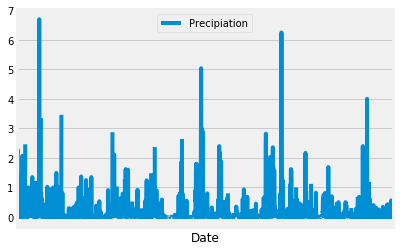

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

Precipitation_data = session.query(Measurement.date)

last_date = Precipitation_data[-1][0]
print(last_date)

Precipitation_data = session.query(Measurement.date,Measurement.prcp)\
                    .filter(Measurement.date > (dt.datetime.strptime(last_date,'%Y-%m-%d') - dt.timedelta(days =365)))\
                    .all()

# # Save the query results as a Pandas DataFrame and set the index to the date column

Measurement_df = pd.DataFrame(Precipitation_data, columns = ["Date","Precipiation"])

# # # Sort the dataframe by date
Measurement_df = Measurement_df.sort_values(by = 'Date')

# # Use Pandas Plotting with Matplotlib to plot the data

Measurement_df.plot(x = 'Date', y = 'Precipiation')

plt.xlabel('Date')
plt.xticks([])
plt.legend(loc = "upper center");


![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Measurement_df.describe()

,Precipiation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?

unique_stations = []
for station in session.query(distinct(Measurement.station),Measurement.station).group_by(Measurement.station):
    if station.station not in unique_stations:
        unique_stations.append(station.station)
        
print(unique_stations)

['USC00511918', 'USC00513117', 'USC00514830', 'USC00516128', 'USC00517948', 'USC00518838', 'USC00519281', 'USC00519397', 'USC00519523']


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station))\
                    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

active_stations_df = pd.DataFrame(active_stations, columns = ["station","counts"])
active_stations_df.head(10)

,station,counts
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 

lowest_temp_recorded = session.query(Measurement.station,func.min(Measurement.tobs)).group_by(Measurement.station)

lowest_temp_recorded_df = pd.DataFrame(lowest_temp_recorded, columns = ["station","lowest temperature"])
lowest_temp_recorded_df.head(9)

,station,lowest temperature
0,USC00511918,53.0
1,USC00513117,59.0
2,USC00514830,58.0
3,USC00516128,58.0
4,USC00517948,58.0
5,USC00518838,58.0
6,USC00519281,54.0
7,USC00519397,56.0
8,USC00519523,56.0


In [16]:
# highest temperature recorded
highest_temp_recorded = session.query(Measurement.station,func.max(Measurement.tobs)).group_by(Measurement.station)
highest_temp_recorded_df = pd.DataFrame(highest_temp_recorded, columns = ["station","highest temperature"])
highest_temp_recorded_df.head(9)

,station,highest temperature
0,USC00511918,87.0
1,USC00513117,85.0
2,USC00514830,85.0
3,USC00516128,84.0
4,USC00517948,87.0
5,USC00518838,83.0
6,USC00519281,85.0
7,USC00519397,87.0
8,USC00519523,85.0


In [17]:
#and average temperature at the most active station?
most_active_station_avg_temp = session.query(Measurement.station,func.avg(Measurement.tobs))\
.group_by(Measurement.station) .order_by(func.count(Measurement.station).desc()).limit(1)

most_active_station_avg_temp_df = pd.DataFrame(most_active_station_avg_temp, columns = ["station","avg temperature"])
most_active_station_avg_temp_df.head(9)

top_station = most_active_station_avg_temp_df["station"][0]
print(top_station)

USC00519281


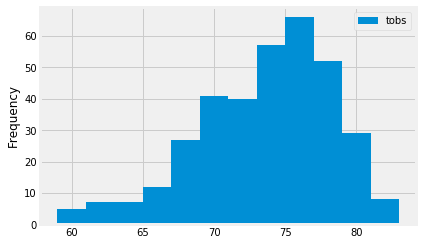

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Temp_data = session.query(Measurement.tobs)\
                    .filter(Measurement.station == str(top_station))\
                    .filter(Measurement.date > (dt.datetime.strptime(last_date,"%Y-%m-%d") - dt.timedelta(days = 365)))

temp_last_12_months_df = pd.DataFrame(Temp_data, columns = ["tobs"])
temp_last_12_months_df["tobs"].plot(kind = "hist",bins = 12)
plt.legend();


![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start = '2011-01-10'
end = '2011-01-25'
my_trip = calc_temps(start,end)
for entry in my_trip:
    tmin = entry[0]
    tavg = entry[1]
    tmax = entry[2]
    

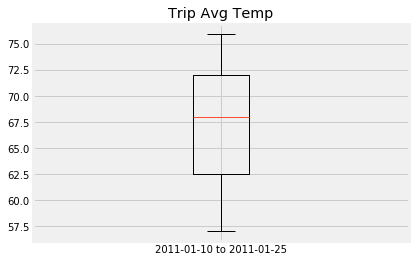

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
xlabel = start + " to " + end
plt.boxplot([tmin,tavg,tmax],labels = [xlabel])
plt.title('Trip Avg Temp');

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

predict_trip_success = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name,\
                                     Station.latitude, Station.longitude, Station.elevation)\
                        .filter(Measurement.date >= start).filter(Measurement.date <= end)\
                        .filter(Measurement.station == Station.station)\
                        .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc())

predict_trip_success_df = pd.DataFrame(predict_trip_success,columns = ["Station ID",\
                                                                       "Total amount of precipitation",
                                                                       "Station Name","Station Latitude",
                                                                       "Station Longitude","Station Elevation"])
predict_trip_success_df.head(10)


,Station ID,Total amount of precipitation,Station Name,Station Latitude,Station Longitude,Station Elevation
0,USC00519281,10.11,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,USC00518838,9.00,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
2,USC00513117,6.11,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,5.75,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,5.50,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00511918,4.33,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
6,USC00516128,3.84,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
7,USC00517948,0.42,"PEARL CITY, HI US",21.39340,-157.97510,11.9
8,USC00519397,0.15,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [33]:
#prep for flask
#precipitation page
import json
Precipitation_data1 = session.query(Measurement.date,Measurement.prcp)
date = []
prcp = []
for entry in Precipitation_data1:
    date.append(entry.date)
    prcp.append(entry.prcp)
date_prcp_dict = zip(date,prcp)
date_prcp_dict = list(date_prcp_dict)
worked = dict(date_prcp_dict)
worked = json.dumps(worked)
worked = json.loads(worked)
#print(json.dumps(worked, indent = 4, sort_keys=True))

##stations page

# print(unique_stations)
# print(str(unique_stations))
stations_json = json.dumps(unique_stations)
stations_json = json.loads(stations_json)
#print(json.dumps(stations_json, indent = 4, sort_keys=True))
#tobs page
tobs_data = session.query(Measurement.date,Measurement.tobs)\
                    .filter(Measurement.date > (dt.datetime.strptime(last_date,'%Y-%m-%d') - dt.timedelta(days =365)))\
                    .all()
tobs_data = dict(tobs_data)
tobs_json = json.dumps(tobs_data)
tobs_json = json.loads(tobs_json)
#print(json.dumps(tobs_json, indent = 4, sort_keys=True))
#<start> page

#<start><end> page

{
    "2016-08-24": 74.0,
    "2016-08-25": 77.0,
    "2016-08-26": 80.0,
    "2016-08-27": 74.0,
    "2016-08-28": 71.0,
    "2016-08-29": 78.0,
    "2016-08-30": 75.0,
    "2016-08-31": 76.0,
    "2016-09-01": 77.0,
    "2016-09-02": 75.0,
    "2016-09-03": 75.0,
    "2016-09-04": 73.0,
    "2016-09-05": 76.0,
    "2016-09-06": 73.0,
    "2016-09-07": 74.0,
    "2016-09-08": 74.0,
    "2016-09-09": 75.0,
    "2016-09-10": 75.0,
    "2016-09-11": 71.0,
    "2016-09-12": 72.0,
    "2016-09-13": 75.0,
    "2016-09-14": 73.0,
    "2016-09-15": 73.0,
    "2016-09-16": 73.0,
    "2016-09-17": 76.0,
    "2016-09-18": 75.0,
    "2016-09-19": 70.0,
    "2016-09-20": 70.0,
    "2016-09-21": 73.0,
    "2016-09-22": 73.0,
    "2016-09-23": 73.0,
    "2016-09-24": 77.0,
    "2016-09-25": 76.0,
    "2016-09-26": 74.0,
    "2016-09-27": 74.0,
    "2016-09-28": 77.0,
    "2016-09-29": 77.0,
    "2016-09-30": 73.0,
    "2016-10-01": 74.0,
    "2016-10-02": 73.0,
    "2016-10-03": 76.0,
    "2016-10-0

In [24]:
from flask import Flask


app = Flask(__name__)

@app.route("/")
def home():
    print("Welcome to the Home page")
    return "Welcome to the 'Home' page"

@app.route("/api/v1.0/precipitation")
def precipitation():
    print("Welcome to the Precipitation page")
    print("---------------------------------------------------\nHere is the Precipitation data:")
    print(json.dumps(worked, indent = 4, sort_keys=True))
    return "You have now entered the 'Precipitation' page"

@app.route("/api/v1.0/stations")
def station():
    print("Welcome to the Stations page")
    print("---------------------------------------------------\nHere are the Stations that were recorded in the dataset:")
    print(json.dumps(stations_json, indent = 4, sort_keys=True))
    return "You have now entered the 'Stations' page"

@app.route("/api/v1.0/tobs")
def tobs():
    print("Welcome to the Temperature Observations page")
    print("---------------------------------------------------\nHere is the Temperature Obeservations data:")
    print(json.dumps(tobs_json, indent = 4, sort_keys=True))
    return "You have now entered the 'Tobs' page"

@app.route("/api/v1.0/<start>")
def start():
    print("Welcome to the Temperature Observations page")
    return "You have now entered the 'Tobs' page"


## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
for date in date_range:
    for entry in daily_normal
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


SyntaxError: invalid syntax (<ipython-input-26-d556d2bc9521>, line 5)

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
